In [9]:
! pip install kaggle

In [10]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
! cp kaggle.json ~/.kaggle/

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets download puneet6060/intel-image-classification

 99% 342M/346M [00:15<00:00, 13.5MB/s]
100% 346M/346M [00:15<00:00, 22.7MB/s]


In [14]:
! unzip intel-image-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [15]:
import cv2
import os
import pandas as pd
import numpy as np

In [16]:
labels = {}
count = 0
img_size = (150,150)

for i in os.listdir("seg_test/seg_test"):
    labels[i] = count 
    count += 1

labels

{'buildings': 1,
 'forest': 0,
 'glacier': 3,
 'mountain': 2,
 'sea': 4,
 'street': 5}

In [17]:
def load_train_data():
    
    train_path = "seg_train/seg_train"
    
    train_images = []
    train_labels = []
    
    for i in os.listdir(train_path):
        imageList = os.listdir(train_path + "/" + i)
        for j in imageList:
            img = cv2.imread(train_path + "/" + i + "/" + j)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            
            train_images.append(img)
            train_labels.append(labels[i])
            
    train_images = np.array(train_images, dtype="float32")
    train_labels = np.array(train_labels, dtype="float32")
        
    return (train_images, train_labels)

In [18]:
def load_test_data():
    
    test_path = "seg_test/seg_test"
    
    test_images = []
    test_labels = []
    
    for i in os.listdir(test_path):
        imageList = os.listdir(test_path + "/" + i)
        for j in imageList:
            img = cv2.imread(test_path + "/" + i + "/" + j)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            
            test_images.append(img)
            test_labels.append(labels[i])
            
    test_images = np.array(test_images, dtype="float32")
    test_labels = np.array(test_labels, dtype="float32")
        
    return (test_images, test_labels)

In [19]:
x_train, x_test = load_train_data()

In [20]:
y_train, y_test = load_test_data()

In [21]:
print("Train : ", x_train.shape)
print("Test : ", y_train.shape)

Train :  (14034, 150, 150, 3)
Test :  (3000, 150, 150, 3)


In [22]:
from sklearn.utils import shuffle 

x_train, x_test = shuffle(x_train, x_test, random_state = 42)

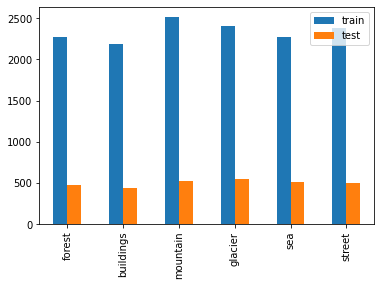

In [23]:
import matplotlib.pyplot as plt
_, train_counts = np.unique(x_test, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
pd.DataFrame({'train': train_counts,
                    'test': test_counts}, 
             index=labels
            ).plot.bar()
plt.show()

In [24]:
x_train = x_train / 255.
y_train = y_train / 255.

In [25]:
from tensorflow.keras.utils import to_categorical

x_test = to_categorical(x_test)

In [26]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobileNet = MobileNetV2(input_shape=(150,150,3), weights="imagenet", include_top=False)

9412608/9406464 [==============================] - 0s 0us/step


In [27]:
for layer in mobileNet.layers:
    layer.trainable = False

In [28]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.models import Sequential
import tensorflow as tf

model = Sequential()
model.add(mobileNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=len(labels), activation="softmax"))

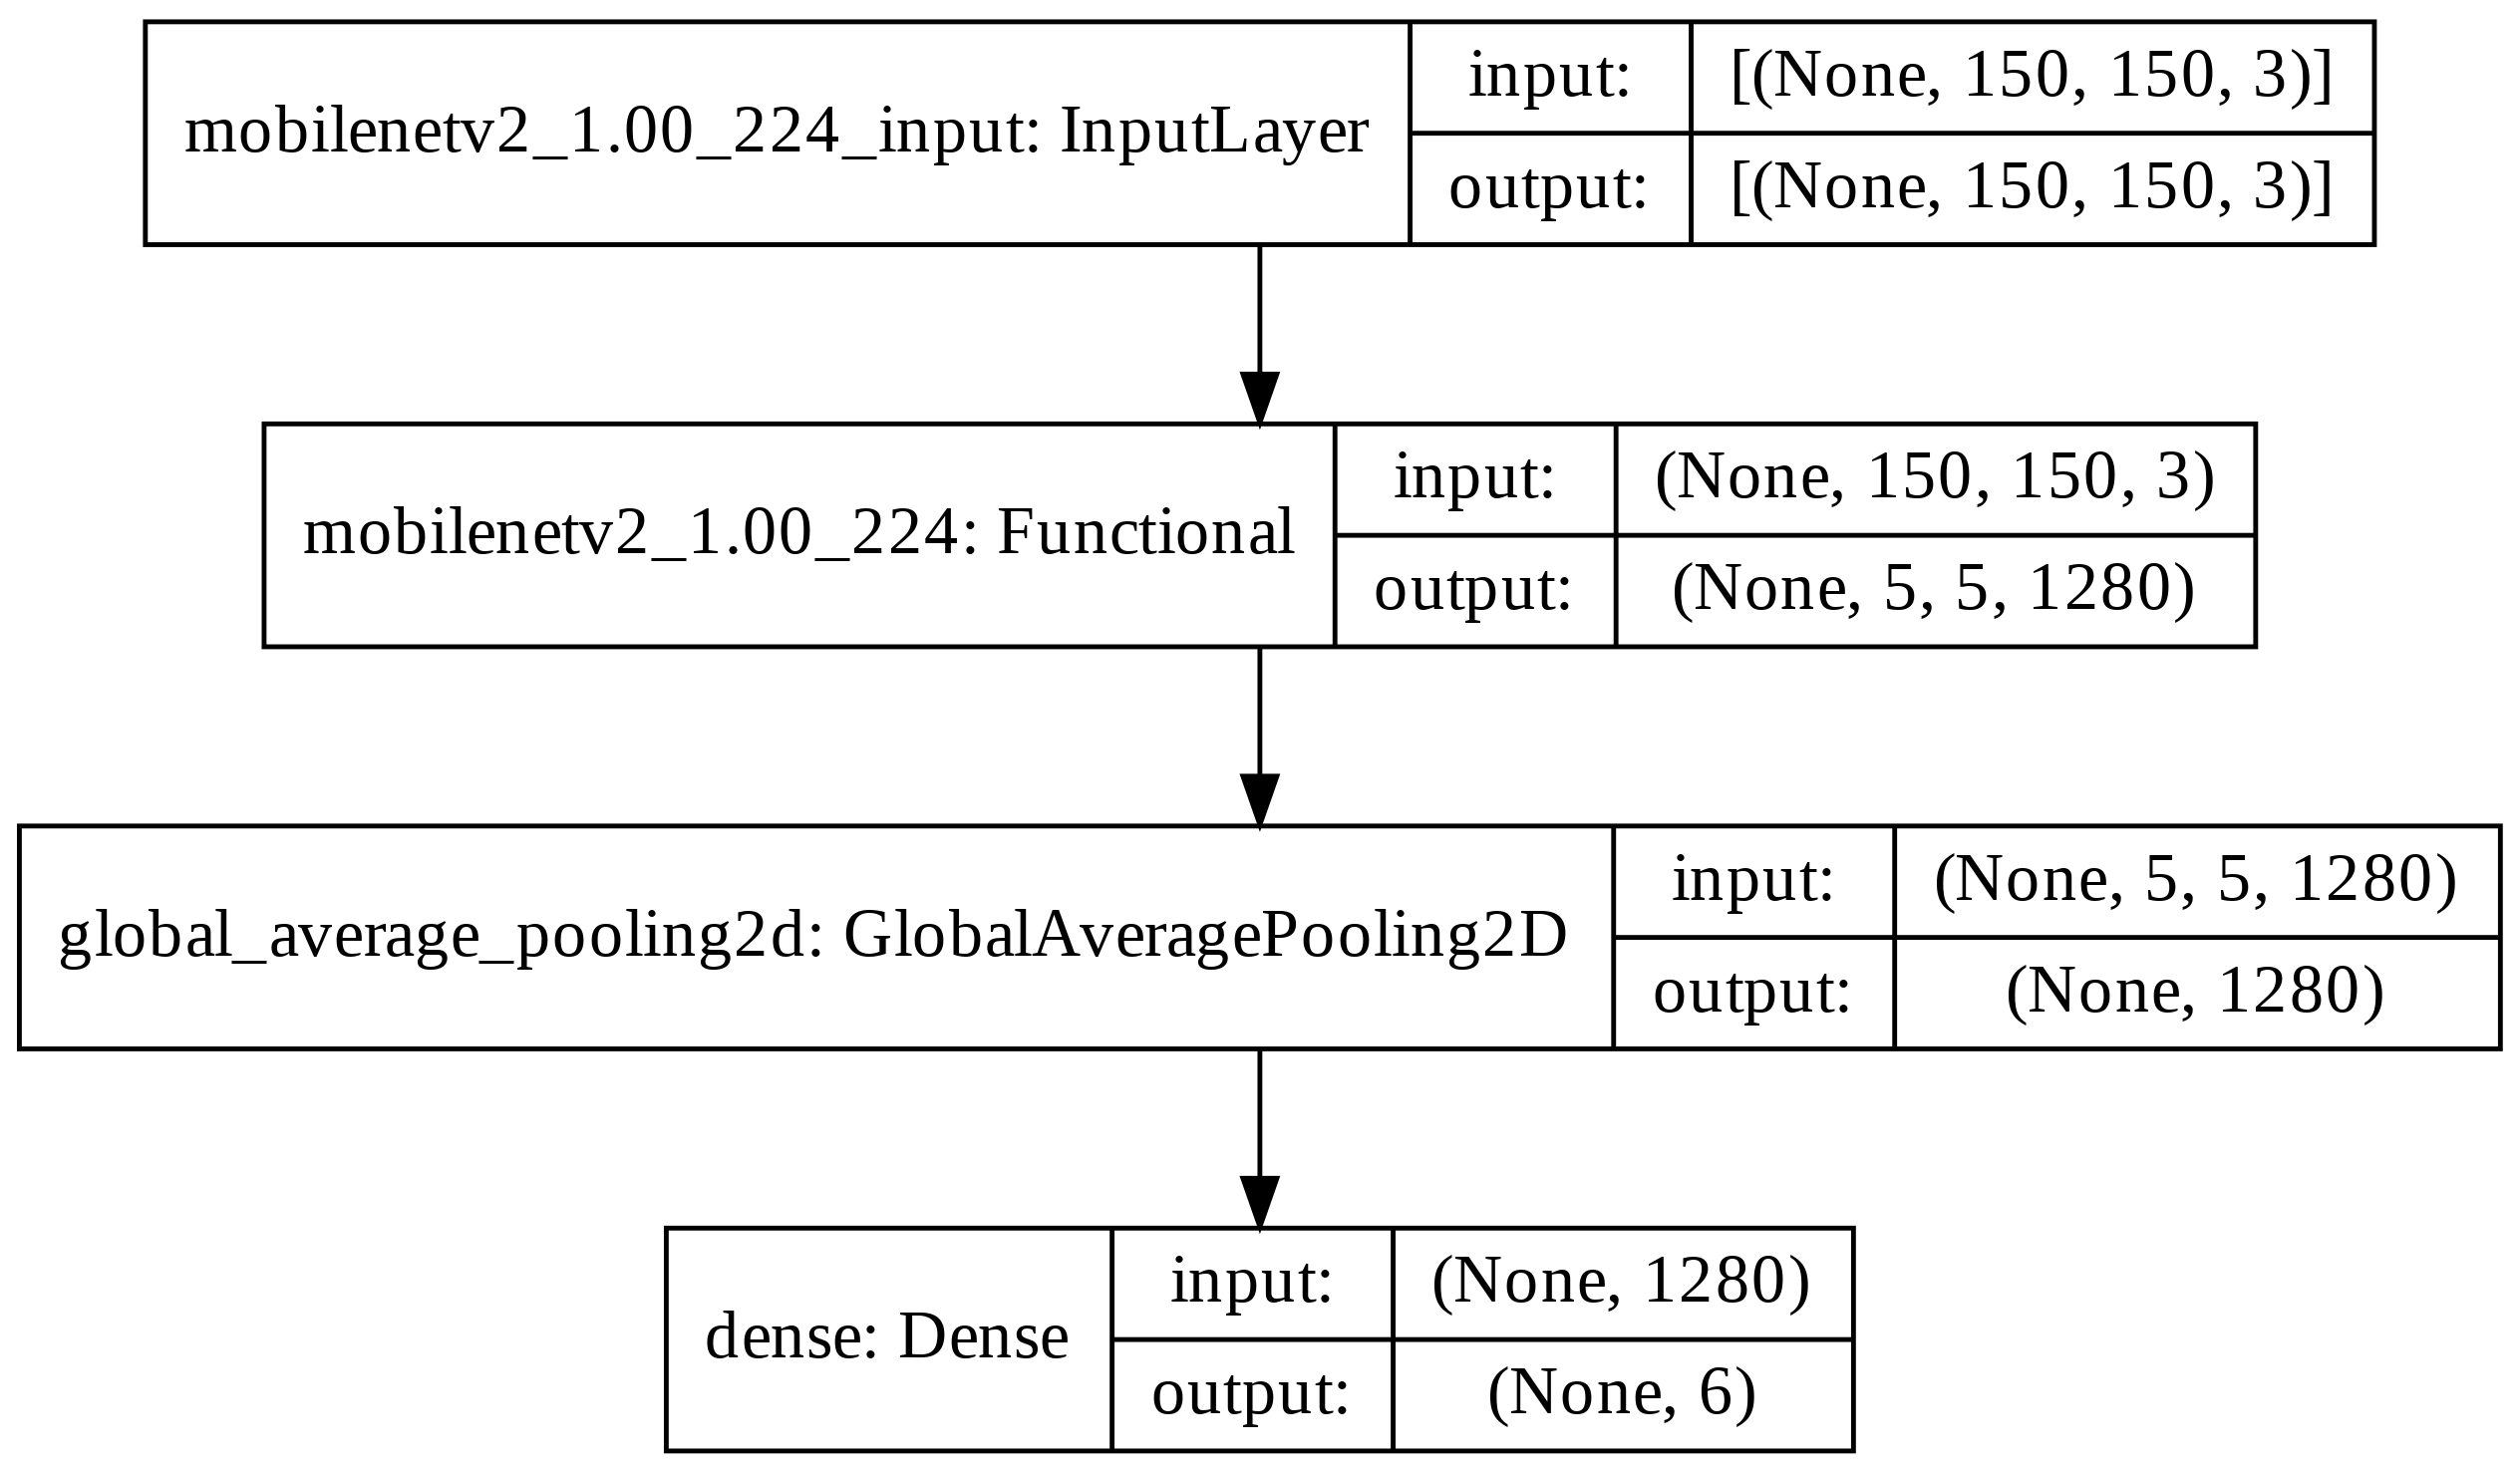

In [29]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_layer_names=True, show_shapes =True, to_file='model.png', dpi=350)

In [30]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss = "categorical_crossentropy", metrics = ["accuracy"])

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

model_check = ModelCheckpoint('best_model.h5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=5, verbose=0, mode='max', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

csv_logger = CSVLogger('train_log.csv', separator=',')

In [32]:
hist = model.fit(x_train, x_test, epochs=50, batch_size=64, validation_split=0.2, callbacks=[model_check, early, reduce_lr, csv_logger])

Epoch 1/50
176/176 [==============================] - 51s 116ms/step - loss: 0.4618 - accuracy: 0.8361 - val_loss: 0.3261 - val_accuracy: 0.8807


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
176/176 [==============================] - 19s 105ms/step - loss: 0.2888 - accuracy: 0.8957 - val_loss: 0.3162 - val_accuracy: 0.8828
Epoch 3/50
176/176 [==============================] - 19s 105ms/step - loss: 0.2560 - accuracy: 0.9072 - val_loss: 0.2788 - val_accuracy: 0.9017
Epoch 4/50
176/176 [==============================] - 18s 105ms/step - loss: 0.2351 - accuracy: 0.9147 - val_loss: 0.3767 - val_accuracy: 0.8611
Epoch 5/50
176/176 [==============================] - 19s 106ms/step - loss: 0.2207 - accuracy: 0.9222 - val_loss: 0.2901 - val_accuracy: 0.8924
Epoch 6/50
176/176 [==============================] - 19s 106ms/step - loss: 0.2059 - accuracy: 0.9254 - val_loss: 0.2873 - val_accuracy: 0.8935
Epoch 7/50
176/176 [==============================] - 18s 105ms/step - loss: 0.1966 - accuracy: 0.9273 - val_loss: 0.2982 - val_accuracy: 0.8970
Epoch 8/50
176/176 [==============================] - 18s 105ms/step - loss: 0.1878 - accuracy: 0.9326 - val_loss: 0.2825 - val_ac

In [33]:
bestModel = tf.keras.models.load_model("./best_model.h5")

In [34]:
def plot_accuracy_loss(history):
    
    fig = plt.figure(figsize=(10,5))

    plt.subplot(221)
    plt.plot(history.history['accuracy'],'bo--', label = "acc")
    plt.plot(history.history['val_accuracy'], 'ro--', label = "val_acc")
    plt.title("train_acc vs val_acc")
    plt.ylabel("accuracy")
    plt.xlabel("epochs")
    plt.legend()

    plt.subplot(222)
    plt.plot(history.history['loss'],'bo--', label = "loss")
    plt.plot(history.history['val_loss'], 'ro--', label = "val_loss")
    plt.title("train_loss vs val_loss")
    plt.ylabel("loss")
    plt.xlabel("epochs")

    plt.legend()
    plt.show()

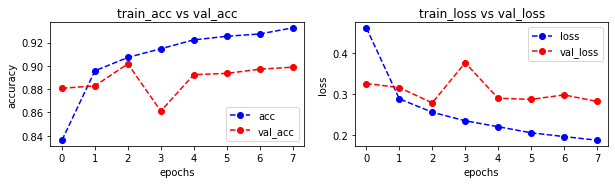

In [35]:
plot_accuracy_loss(hist)

In [36]:
y_pred = bestModel.predict(y_train)
y_pred = np.argmax(y_pred, axis=-1)

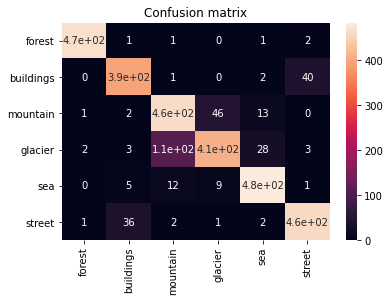

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
ax = plt.axes()
sns.heatmap(cm, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=labels, 
           yticklabels=labels, ax = ax)
ax.set_title('Confusion matrix')
plt.show()